In [513]:
using Pkg
Pkg.activate("/media/mat/HDD/EnKF/")

"/media/mat/HDD/EnKF/Project.toml"

In [514]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using ProgressMeter
using OrdinaryDiffEq

In [515]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
clibrary(:colorbrewer)
pyplot()

Plots.PyPlotBackend()

We are interested in simulating the Lorenz attractor
            $$ ẋ = \sigma(y - x)\\
       ẏ = x(\rho-z) - y\\
       ż = xy - \beta z$$

Define parameters of the Lorenz attractor

In [516]:
function lorenz(du,u,p,t)
 du[1] = 10.0*(u[2]-u[1])
 du[2] = u[1]*(28.0-u[3]) - u[2]
 du[3] = u[1]*u[2] - (8/3)*u[3]
end


u0 = [10.0; -5.0; 2.0]
tspan = (0.0,40.0)

Δt = 1e-2
T = tspan[1]:Δt:tspan[end]

prob = ODEProblem(lorenz,u0,tspan)
sol = solve(prob, RK4(), adaptive = false, dt = Δt)

integrator = init(prob, RK4(), adaptive =false, dt = Δt, save_everystep=false)

t: 0.0
u: 3-element Array{Float64,1}:
 10.0
 -5.0
  2.0

In [517]:
states = [deepcopy(u0)]

1-element Array{Array{Float64,1},1}:
 [10.0, -5.0, 2.0]

In [518]:
for t in T[1:end-1]
    step!(integrator)
    push!(states, deepcopy(integrator.u))
end

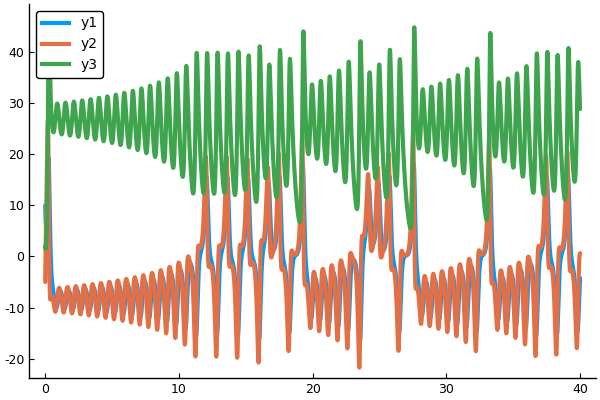

In [519]:
plot(T, hcat(states...)[1,:], linewidth  = 3)
plot!(T, hcat(states...)[2,:], linewidth = 3)
plot!(T, hcat(states...)[3,:], linewidth = 3)

Define propagation function fprop

In [520]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
        for j=1:50
        step!(integrator)
        end
        ENS.S[i] = deepcopy(integrator.u)

    end
    
    return ENS
end

In [521]:
fprop = PropagationFunction()

PropagationFunction()

Define measurement function m

In [522]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    return [s[1]+s[2]+s[3]]
end

In [523]:
function (::MeasurementFunction)(t::Float64) 
    return reshape([1.0, 1.0 , 1.0],(1,3))
end

In [524]:
m = MeasurementFunction()

MeasurementFunction()

Define  real measurement function z, always measure the true state but is corrupted by noise ϵ

In [525]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    let s = sol(t)
    fill!(ENS, [deepcopy(s[1]+s[2]+s[3])])
    end
    return ENS
end

In [526]:
z = RealMeasurementFunction()

RealMeasurementFunction()

Define covariance inflation

In [652]:
# A = MultiAdditiveInflation(3, 1.01, MvNormal(zeros(3), 1.0*I))
# A = RTPSAdditiveInflation(1.0, MvNormal(zeros(3), 1.0*I))
A = RTPSInflation(0.95)
# A = IdentityInflation()

RTPSInflation(0.95)

Define noise covariance

In [653]:
ϵ = AdditiveInflation(MvNormal(zeros(1), 3.0*I));

In [654]:
N = 5
NZ = 1
isinflated = true
isfiltered = false
isaugmented = false;

In [655]:
ens = initialize(N, MvNormal([20.0, -10.0, 10.0], 2.0*I))
estimation_state = [deepcopy(ens.S)]

tmp = deepcopy(u0)
true_state = [deepcopy(u0)];

In [656]:
g = FilteringFunction();

In [657]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented);

### Ensemble Kalman filter estimation

In [658]:
Δt = 1e-2
Tsub = 0.0:50*Δt:40.0-50*Δt

@showprogress for (n,t) in enumerate(Tsub)

    global ens
#     enkf.f(t, ens)
    t, ens, _ = enkf(t, 50*Δt, ens)
    push!(estimation_state, deepcopy(ens.S))
    

end

In [659]:
s =  hcat(sol(T).u...)
ŝ =  hcat(mean.(estimation_state)...)
ssub =  hcat(sol(Tsub).u...)
norm(ssub - ŝ[:,1:end-1])/norm(ssub)

0.36967279260622177

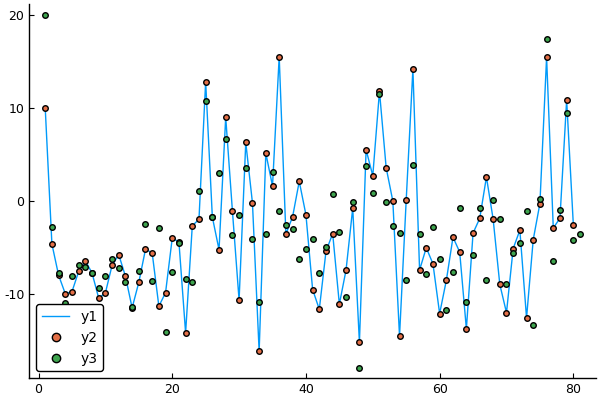

In [660]:
plot(ssub[1,:])
scatter!(ssub[1,:])
scatter!(ŝ[1,:])

In [661]:
?rmse

search: TerminateSteadyState RealMeasurementFunction NormalInverseGaussian

Couldn't find rmse
Perhaps you meant rm, rate, reset, Base, msd, else, rmul!, remake, rem or frame


No documentation found.

Binding `rmse` does not exist.


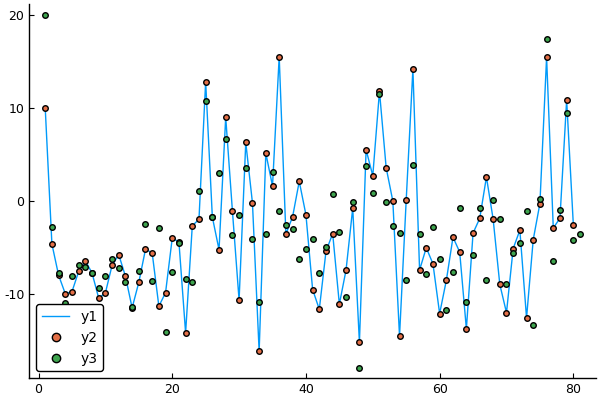

In [662]:
plot(ssub[1,:])
scatter!(ssub[1,:])
scatter!(ŝ[1,:])

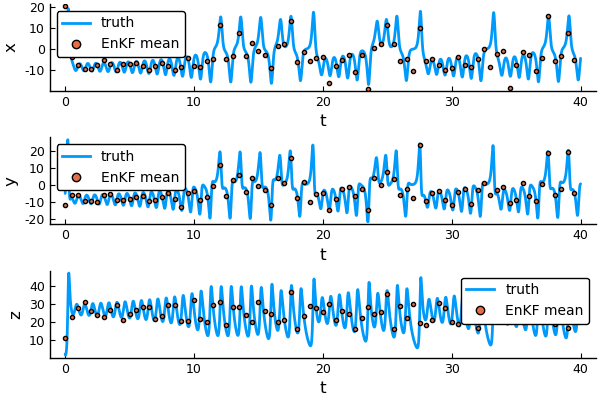

In [620]:
plt = plot(layout = (3, 1), legend = true)
plot!(plt[1], T, s[1,1:end], linewidth = 2, label = "truth")
scatter!(plt[1], Tsub, ŝ[1,1:end-1], linewidth = 2, markersize = 3, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash)

plot!(plt[2], T, s[2,1:end], linewidth = 2, label = "truth")
scatter!(plt[2], Tsub, ŝ[2,1:end-1], linewidth = 2, markersize = 3, label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash)

plot!(plt[3], T, s[3,1:end], linewidth = 2, label = "truth")
scatter!(plt[3], Tsub, ŝ[3,1:end-1], linewidth = 2, markersize = 3, label = "EnKF mean", xlabel = "t", ylabel = "z", linestyle =:dash)

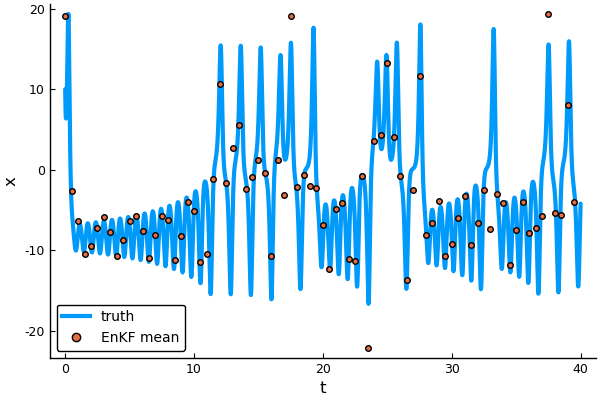

In [607]:
plot(T, s[1,:], linewidth = 3, label = "truth")
# plot!(Tsub, ŝ[1,1:end-1], linewidth = 3, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash)
scatter!(Tsub, ŝ[1,1:end-1], linewidth = 3, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash)

In [26]:
# plot(s[1,:], s[2,:], s[3,:], linewidth = 2, label = "truth", legend = true)
# plot!(ŝ[1,1:end-1], ŝ[2,1:end-1], ŝ[3,1:end-1], linewidth = 2, label = "EnKF mean", xlabel = "x", 
#     ylabel = "y", zlabel ="z", linestyle = :solid)
# scatter!(ŝ[1,:], ŝ[2,:], ŝ[3,:], linewidth = 2, label = "EnKF mean", xlabel = "x", 
#     ylabel = "y", zlabel ="z", linestyle = :solid)